<a href="https://colab.research.google.com/github/racoope70/daytrading-with-ml/blob/main/Model_Selector_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# === IMPORTS ===
import os
import ast
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive

# === MOUNT GOOGLE DRIVE ===
drive.mount('/content/drive', force_remount=True)

# === CONFIGURATION ===
SELECTOR_DIR = "/content/drive/MyDrive/Model_Selector/Result"
COMBINED_CSV = os.path.join(SELECTOR_DIR, "all_models_selector_ready.csv")
BEST_XLSX = os.path.join(SELECTOR_DIR, "best_models_by_ticker.xlsx")

# === STEP 1: LOAD ALL *_model_selector.csv FILES ===
model_files = [f for f in os.listdir(SELECTOR_DIR) if f.endswith('_model_selector.csv')]
model_dfs = []

for file in model_files:
    file_path = os.path.join(SELECTOR_DIR, file)
    try:
        df = pd.read_csv(file_path)
        df["Model"] = file.replace("_model_selector.csv", "")
        model_dfs.append(df)
        print(f" Loaded: {file}")
    except Exception as e:
        print(f" Error loading {file}: {e}")

if not model_dfs:
    raise ValueError(" No model selector CSVs found in folder.")

# === STEP 2: COMBINE ALL ===
master_df = pd.concat(model_dfs, ignore_index=True)
master_df.to_csv(COMBINED_CSV, index=False)
print(f"\n📂 Combined model selector results saved to:\n{COMBINED_CSV}")

# === STEP 3: CLEANING & CASTING ===
df = master_df.copy()
print(f"\n📐 Combined shape: {df.shape}")

# Fix 'Signal Map' if exists
if 'Signal Map' in df.columns:
    df['Signal Map'] = df['Signal Map'].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith("{") else x
    )

# Drop legacy 'score' column if present
if 'score' in df.columns:
    df.drop(columns=['score'], inplace=True)

# Convert important columns to numeric
for col in ['Sharpe', 'Return', 'Accuracy']:
    df[col] = pd.to_numeric(df.get(col), errors='coerce').fillna(0)

# Drop rows missing critical info
df = df[df['Ticker'].notnull() & df['Model'].notnull()]
df = df[df['Sharpe'].notna() & df['Return'].notna()]

# === STEP 4: COMPOSITE SCORE ===
df['Score'] = (
    df['Sharpe'] * 0.4 +
    df['Return'] * 0.3 +
    df['Accuracy'] * 0.3
)

# === STEP 5: SELECT BEST MODEL PER TICKER ===
best_models = df.sort_values(['Ticker', 'Score'], ascending=[True, False]) \
                .groupby('Ticker').first().reset_index()

# === STEP 6: EXPORT BEST MODELS ===
best_models.to_excel(BEST_XLSX, index=False)
print(f"\n📤 Best models per ticker saved to:\n{BEST_XLSX}")

# === STEP 7: SUMMARY OUTPUT ===
print("\nModel win count:")
print(best_models['Model'].value_counts())

print("\n Top 10 Models by Score:")
display(best_models.sort_values('Score', ascending=False).head(10))


Mounted at /content/drive
 Loaded: kmeans_databased_model_selector.csv
 Loaded: sac_databased_model_selector.csv
 Loaded: ppo_databased_model_selector.csv
 Loaded: a2c_databased_model_selector.csv
 Loaded: deep_sarsa_databased_model_selector.csv
 Loaded: dqn_databased_model_selector.csv
 Loaded: lightgbm_databased_model_selector.csv
 Loaded: rf_databased_model_selector.csv
 Loaded: xgb_databased_model_selector.csv

📂 Combined model selector results saved to:
/content/drive/MyDrive/Model_Selector/Result/all_models_selector_ready.csv

📐 Combined shape: (1066, 26)

📤 Best models per ticker saved to:
/content/drive/MyDrive/Model_Selector/Result/best_models_by_ticker.xlsx

Model win count:
Model
deep_sarsa_databased    29
a2c_databased           12
xgb_databased           10
rf_databased             7
dqn_databased            2
Name: count, dtype: int64

 Top 10 Models by Score:


,Ticker,Final Market,Final Strategy,Sharpe,Drawdown,Final Portfolio Value,Signal Map,Accuracy,Precision,Recall,...,Winner,PPO_Portfolio,Drawdown_%,Final_Portfolio,Final_Hold,Return_%,Return_Hold_%,Train Period,Test Period,Score
14,CSCO,1.405129,1.620620,0.3821,456.25,162062.016689,"{0: 'Buy', 1: 'Hold', 2: 'Sell'}",0.0145,0.722222,0.013225,...,Buy & Hold,100000.00,0.00,738062.53,100000.00,0.00,0.00,2022-04-20 to 2023-04-20,2023-04-20 to 2023-06-19,191.57519
52,TSLA,1.627410,0.548327,0.7238,748.54,54832.743267,"{0: 'Buy', 1: 'Hold', 2: 'Sell'}",0.3000,0.520800,0.516500,...,Buy & Hold,100000.00,0.00,603186.97,169136.48,69.14,69.14,2022-04-20 to 2023-04-20,2023-04-20 to 2023-06-19,151.33652
46,PM,1.748174,1.748174,1.0449,104.08,174817.442109,{1: 'Buy'},0.3272,0.576281,1.000000,...,Buy & Hold,100000.00,0.00,584466.08,163009.65,63.01,63.01,2021-10-22 to 2022-10-22,2022-10-22 to 2022-12-21,145.85712
33,MCD,1.188255,1.241633,0.3928,217.31,124163.281234,"{2: 'Buy', 0: 'Hold', 1: 'Sell'}",0.5249,0.724138,0.093855,...,Buy & Hold,100000.00,0.00,375393.67,103905.27,3.91,3.91,2022-10-17 to 2023-10-17,2023-10-17 to 2023-12-16,82.93159
24,IBM,1.594097,1.773266,0.8560,127.95,177326.602446,"{2: 'Buy', 1: 'Hold'}",0.4468,0.659420,0.089921,...,Buy & Hold,100000.00,0.00,372706.36,193286.18,93.29,93.29,2022-10-17 to 2023-10-17,2023-10-17 to 2023-12-16,82.28944
42,ORCL,1.396069,1.485926,0.5822,369.67,148592.583999,"{0: 'Buy', 2: 'Hold'}",0.5191,0.543478,0.026998,...,Buy & Hold,100000.00,0.00,344175.37,69259.63,-30.74,-30.74,2022-04-20 to 2023-04-20,2023-04-20 to 2023-06-19,73.64261
8,AVGO,1.838597,1.176174,0.6266,205.69,117617.443082,"{1: 'Buy', 0: 'Hold'}",0.5208,0.598945,0.239451,...,Buy & Hold,100000.00,0.00,331577.42,212114.57,112.11,112.11,2022-04-20 to 2023-04-20,2023-04-20 to 2023-06-19,69.88088
2,ABT,1.297172,1.276257,0.6262,143.38,127625.736162,"{0: 'Buy', 2: 'Hold', 1: 'Sell'}",0.0919,0.541300,0.974000,...,Buy & Hold,137819.18,22.14,322824.44,132754.07,32.75,32.75,2022-10-17 to 2023-10-17,2023-10-17 to 2023-12-16,67.12405
3,ACN,1.083591,1.186444,0.3820,1072.54,118644.394288,"{2: 'Buy', 0: 'Hold', 1: 'Sell'}",0.0023,0.536160,0.473568,...,Buy & Hold,100000.00,0.00,318621.21,106204.66,6.20,6.20,2022-10-17 to 2023-10-17,2023-10-17 to 2023-12-16,65.73949
39,NFLX,NaN,NaN,0.8262,71.82,NaN,None,0.2260,NaN,NaN,...,None,NaN,NaN,305758.73,NaN,NaN,NaN,None,None,62.12628


<Figure size 1400x600 with 0 Axes>

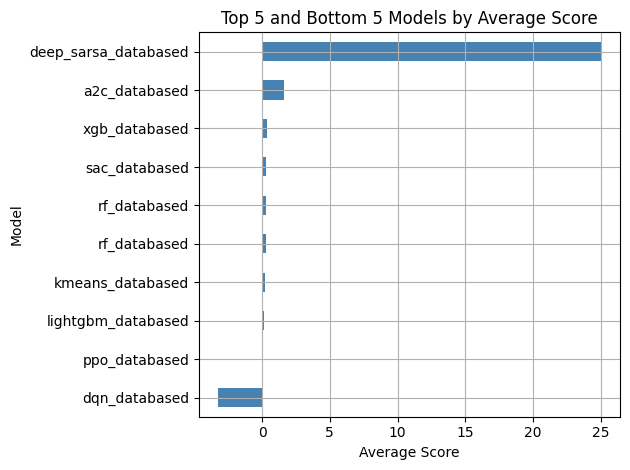

<Figure size 1200x600 with 0 Axes>

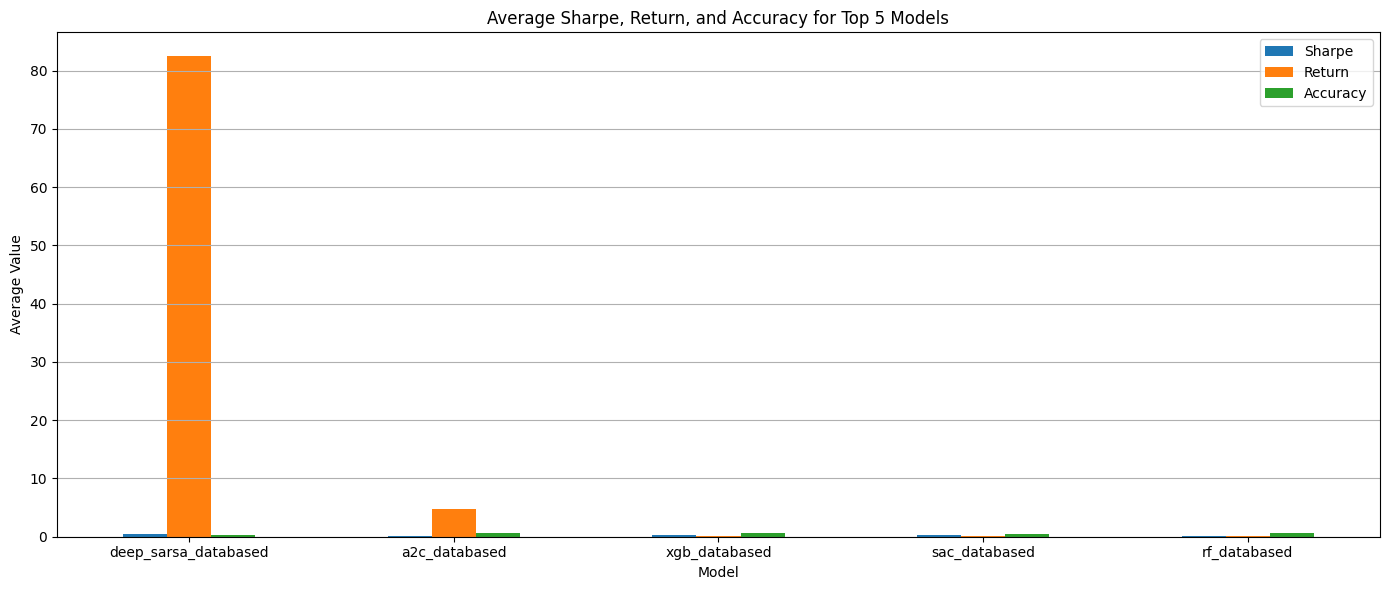

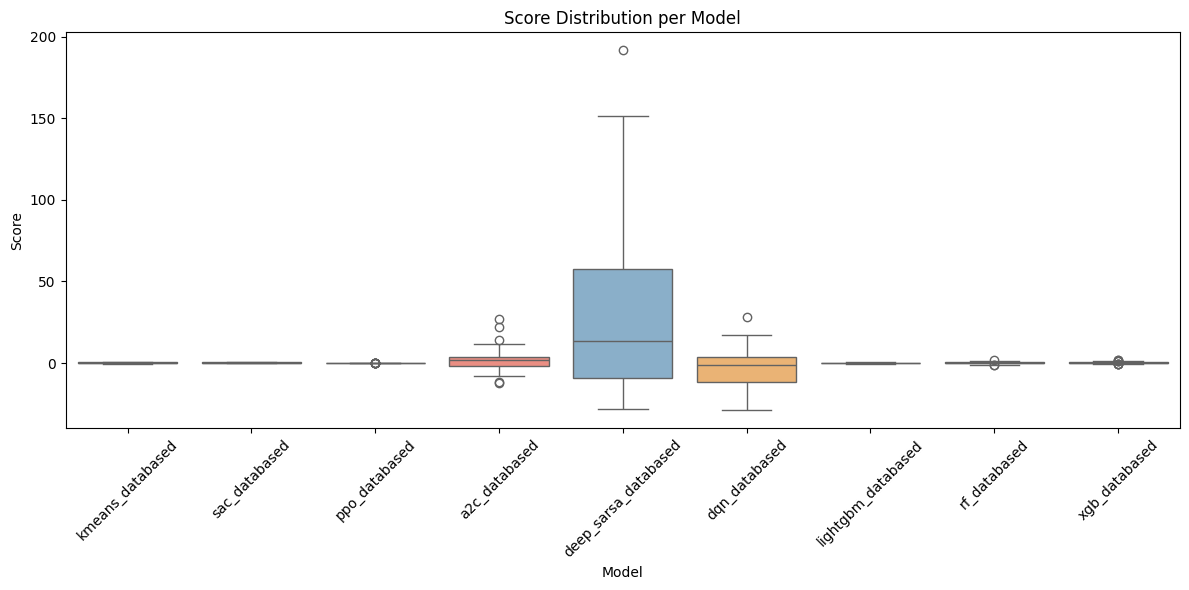

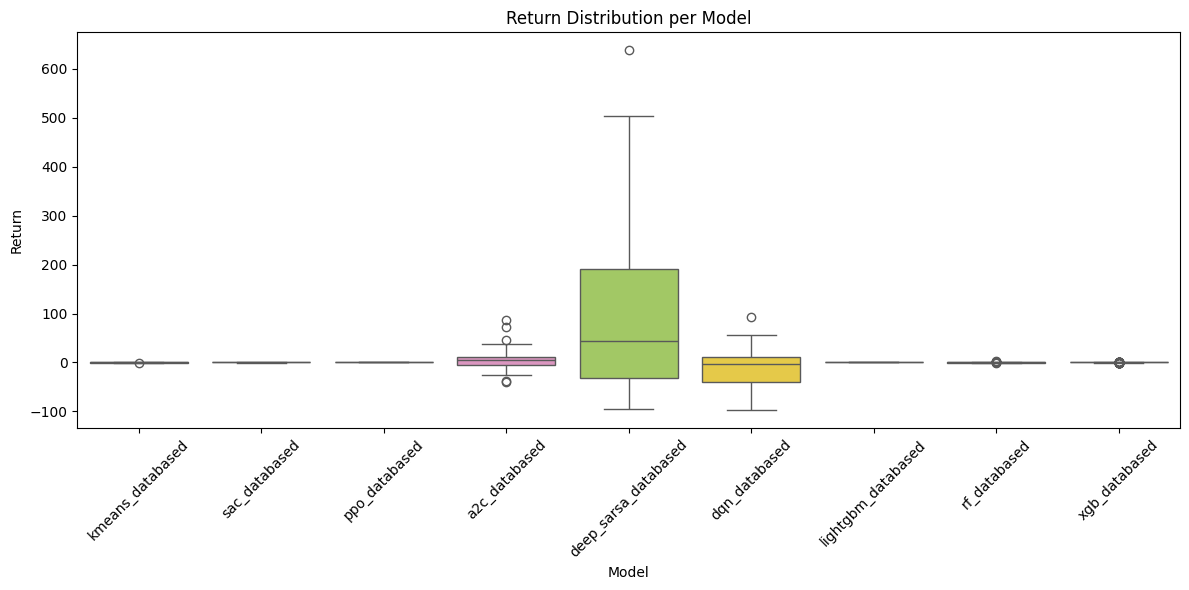

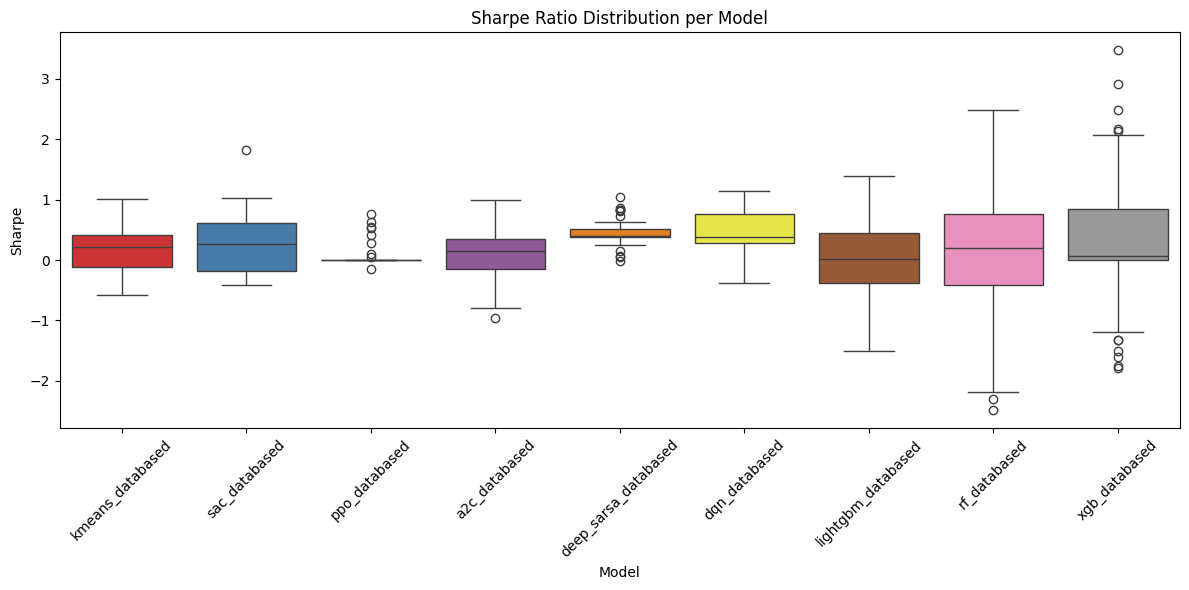

In [5]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# === Ensure numeric types for plotting ===
for col in ['Sharpe', 'Return', 'Accuracy', 'Score']:
    df[col] = pd.to_numeric(df.get(col), errors='coerce').fillna(0)

# === Compute model averages ===
model_means = df.groupby("Model")[['Sharpe', 'Return', 'Accuracy', 'Score']].mean().sort_values("Score", ascending=False)

# === Select Top 5 and Bottom 5 Models ===
top5_models = model_means.head(5)
bottom5_models = model_means.tail(5)

# === Combine for Top & Bottom Chart ===
top_bottom_combined = pd.concat([top5_models, bottom5_models])

# === Plot 1: Top & Bottom 5 Models by Average Score ===
plt.figure(figsize=(14, 6))
top_bottom_combined[['Score']].sort_values("Score").plot(kind='barh', legend=False, color='steelblue')
plt.title("Top 5 and Bottom 5 Models by Average Score")
plt.xlabel("Average Score")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot 2: Average Metric Comparison (Top 5 only) ===
plt.figure(figsize=(12, 6))
top5_models[['Sharpe', 'Return', 'Accuracy']].plot(kind='bar', figsize=(14, 6))
plt.title("Average Sharpe, Return, and Accuracy for Top 5 Models")
plt.ylabel("Average Value")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# === Plot 3: Score Distribution per Model ===
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="Model", y="Score", hue="Model", palette="Set3", dodge=False)
plt.title("Score Distribution per Model")
plt.legend([],[], frameon=False)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === Plot 4: Return Distribution per Model ===
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="Model", y="Return", hue="Model", palette="Set2", dodge=False)
plt.title("Return Distribution per Model")
plt.legend([],[], frameon=False)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === Plot 5: Sharpe Ratio Distribution per Model ===
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="Model", y="Sharpe", hue="Model", palette="Set1", dodge=False)
plt.title("Sharpe Ratio Distribution per Model")
plt.legend([],[], frameon=False)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
